In [11]:
import sympy
from sympy import I, re, im
from sympy.parsing.sympy_parser import (parse_expr, standard_transformations,
                                        implicit_multiplication_application,convert_xor)
from IPython.display import display
sympy.init_printing(use_latex='mathjax')
import numpy as np
np.set_printoptions(suppress=True)
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit, generate_preset_pass_manager, transpile
from qiskit_ibm_runtime import SamplerV2 as Sampler, EstimatorV2 as Estimator, QiskitRuntimeService
from qiskit_aer import AerSimulator
import matplotlib.pyplot as plt

In [15]:

func_str = input("Enter the function to integrate (e.g., sin(x) * exp(-x)): ")
lower_limit_str = input("Enter the lower limit of integration (e.g., 0): ")
upper_limit_str = input("Enter the upper limit of integration (e.g., pi): ")

# variables
x = sympy.symbols('x',real=True)

try:
    # Parse inputs
    local_dict= {'x':x, 'I':I, 'i':I}
    global_dict= sympy.__dict__
    transformations = standard_transformations + (implicit_multiplication_application,convert_xor)
    
    func_expr = parse_expr(func_str,
                        local_dict=local_dict,
                        global_dict=global_dict,
                        transformations=transformations)

    lower_limit = sympy.sympify(lower_limit_str)
    upper_limit = sympy.sympify(upper_limit_str)

    func_real= sympy.simplify(re(func_expr))
    func_imag= sympy.simplify(im(func_expr))

    # Display integration expression
    integral_expr = sympy.Integral(func_expr, (x, lower_limit, upper_limit))

    print("Entered definite integral Mathematical expression:")
    if func_imag==0:
        print("The function is PURELY REAL:")
        display(integral_expr)

    else:
        integral_real= sympy.Integral(func_real,(x,lower_limit, upper_limit))
        integral_imag= sympy.Integral(func_imag, (x, lower_limit, upper_limit))

        print("The function is complex. Splitting into real and imaginary parts:")
        display(sympy.Eq(integral_expr, integral_real + I*integral_imag))

except (sympy.SympifyError, SyntaxError) as e:
    print(f"\nError: Could not parse the input. Please check your expression. Details: {e}")



Entered definite integral Mathematical expression:
The function is complex. Splitting into real and imaginary parts:


π                                      
⌠           π               π          
⎮  ⅈ⋅x      ⌠               ⌠          
⎮ ℯ    dx = ⎮ cos(x) dx + ⅈ⋅⎮ sin(x) dx
⌡           ⌡               ⌡          
0           0               0          

In [17]:
# Number of Samples N= 2^n
num_qubits= 13
N= 2**num_qubits

In [18]:
# Discretize func_expr

upper_limit= float(upper_limit)
lower_limit= float(lower_limit)

limits_difference =upper_limit- lower_limit

g_callable= sympy.lambdify(x, func_real, 'numpy')
h_callable= sympy.lambdify(x, func_imag, 'numpy')

# N random samples
x_array = np.random.uniform(lower_limit,upper_limit,N)


y_real_array= g_callable(x_array)
max_element_real= np.max(y_real_array)
min_element_real= np.min(y_real_array)

# Normalize the samples
normalized_y_real= (y_real_array-min_element_real)/(max_element_real-min_element_real)

print("The Real Normalized N-Values are:")
print(normalized_y_real)


if func_imag!=0:
    y_imag_array= h_callable(x_array)

    max_element_imag= np.max(y_imag_array)
    min_element_imag= np.min(y_imag_array)

    # Normalize the samples
    normalized_y_imag= (y_imag_array-min_element_imag)/(max_element_imag-min_element_imag)

    print("The Imaginary Normalized N-Values are:")
    print(normalized_y_imag)






The Real Normalized N-Values are:
[0.01321929 0.44546094 0.46052966 ... 0.4267823  0.61612536 0.83148648]
The Imaginary Normalized N-Values are:
[0.22820753 0.9940315  0.99687844 ... 0.98921719 0.97264821 0.74857226]


In [25]:
classical_iterations_real= np.cumsum(normalized_y_real, dtype= float)

# Average
for i in range(N):
    classical_iterations_real[i]=classical_iterations_real[i]/(i+1)

# Denormalize
classical_iterations_real= (classical_iterations_real*(max_element_real-min_element_real))+min_element_real
# Integral
Classical_integral_real= classical_iterations_real*(upper_limit-lower_limit)
Classical_integral_imag=0

if func_imag!=0:
    classical_iterations_imag= np.cumsum(normalized_y_imag, dtype= float)

    # Average
    for i in range(N):
        classical_iterations_imag[i]=classical_iterations_imag[i]/(i+1)

    # Denormalize
    classical_iterations_imag= (classical_iterations_imag*(max_element_imag-min_element_imag))+min_element_imag
    # Integral
    Classical_integral_imag= classical_iterations_imag*(upper_limit-lower_limit)


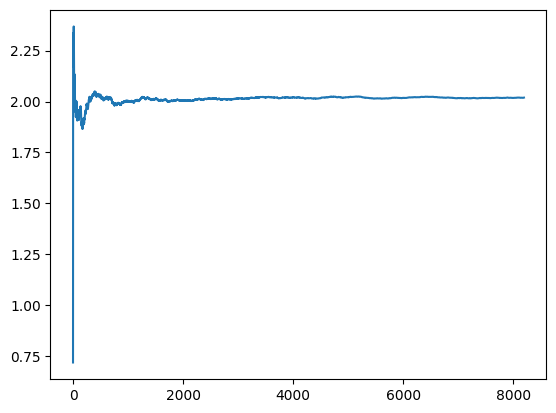

In [26]:
plt.xlabel= "Iterations"
plt.ylabel= "Value"
plt.plot(Classical_integral_imag)

In [27]:
classical_answer= Classical_integral_real[N-1]+ I*Classical_integral_imag[N-1]
print("Classical Integration Answer:")
display(classical_answer)

Classical Integration Answer:


-0.0207897266986729 + 2.01925740115892⋅ⅈ

In [ ]:
service = QiskitRuntimeService(name="qiskit_adi")
# Get a backend
backend = AerSimulator()
#backend = service.least_busy(operational=True, simulator=False)
#backend= service.backend(name='ibm_torino')
print(f"We are using the {backend.name} quantum computer")
shots= 1024
sampler = Sampler(mode=backend)